<!-- Project Title with Main Image -->
<div style="text-align: center; margin-top: 30px;">
    <h1 style="color: #2E7D32; font-family: 'Georgia', serif; border: none; padding: 20px; margin-top: 20px; display: block; background-color: transparent;">
        <i class="fa fa-paw" style="margin-right: 10px; font-size: 32px;"></i>
        Animal Image Classification Project
    </h1>
    <img src="https://img.freepik.com/free-vector/diagram-showing-food-web-rainforest_1308-61671.jpg?t=st=1722975703~exp=1722979303~hmac=2d45a1cb41f8499ac23bf6d682ca8feb3efecc24def6e8a0024360a7dee92a33&w=826" alt="Notebook Cover" style="width: 100%; max-width: 600px; border-radius: 10px;"/>
</div>

<!-- Import Libraries -->
<h2 style="color: #000; font-family: 'Georgia', serif; border: 1px solid #BDBDBD; padding: 10px; margin-top: 20px; display: flex; align-items: center; background-color: #F5F5F5; border-radius: 5px;">
    <i class="fa fa-code" style="margin-right: 10px;"></i>
    Import Libraries
</h2>

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import plotly.graph_objects as go
import plotly.express as px

ModuleNotFoundError: No module named 'seaborn'

In [2]:
# Paths to the dataset
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"
labels_file = "/kaggle/input/animal-image-dataset-90-different-animals/name of the animals.txt"

In [3]:
# Reading labels
with open(labels_file, 'r') as f:
    animal_names = f.read().split('\n')

In [4]:
# Display the first few animal names
animal_names[:10]

['antelope',
 'badger',
 'bat',
 'bear',
 'bee',
 'beetle',
 'bison',
 'boar',
 'butterfly',
 'cat']

<!-- EDA -->
<h2 style="color: #000; font-family: 'Georgia', serif; border: 1px solid #BDBDBD; padding: 10px; margin-top: 20px; display: flex; align-items: center; background-color: #F5F5F5; border-radius: 5px;">
    <i class="fa fa-chart-bar" style="margin-right: 10px;"></i>
    Exploratory Data Analysis (EDA)
</h2>

In [5]:
# Display distribution of animal classes
animal_counts = {animal: len(os.listdir(os.path.join(dataset_path, animal))) for animal in animal_names}
animal_counts_df = pd.DataFrame(list(animal_counts.items()), columns=['Animal', 'Count'])
animal_counts_df = animal_counts_df.sort_values(by='Count', ascending=False)

fig = px.bar(animal_counts_df, x='Animal', y='Count', title='Distribution of Animal Classes', labels={'Animal': 'Animal', 'Count': 'Number of Images'},
             color='Count', color_continuous_scale='Viridis', template='plotly_dark')
fig.update_layout(title_font_size=24, title_x=0.5, xaxis_title_font_size=18, yaxis_title_font_size=18, font=dict(family="Arial, sans-serif", size=14))
fig.show()

<!-- Data Preprocessing -->
<h2 style="color: #000; font-family: 'Georgia', serif; border: 1px solid #BDBDBD; padding: 10px; margin-top: 20px; display: flex; align-items: center; background-color: #F5F5F5; border-radius: 5px;">
    <i class="fa fa-cogs" style="margin-right: 10px;"></i>
    Data Preprocessing
</h2>

In [6]:
# Image Preprocessing using OpenCV
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    return image

In [7]:
# Create dataset
data = []
labels = []

for animal in animal_names:
    animal_dir = os.path.join(dataset_path, animal)
    for img_name in os.listdir(animal_dir):
        img_path = os.path.join(animal_dir, img_name)
        data.append(preprocess_image(img_path))
        labels.append(animal)

data = np.array(data)
labels = np.array(labels)

In [8]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

<!-- Model Training -->
<h2 style="color: #000; font-family: 'Georgia', serif; border: 1px solid #BDBDBD; padding: 10px; margin-top: 20px; display: flex; align-items: center; background-color: #F5F5F5; border-radius: 5px;">
    <i class="fa fa-dumbbell" style="margin-right: 10px;"></i>
    Model Training
</h2>

In [9]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [10]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
# Load the EfficientNetB3 model with pre-trained weights
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some of the top layers of EfficientNetB3
for layer in base_model.layers[-50:]:  # Fine-tune top layers
    layer.trainable = True

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(animal_names), activation='softmax')
])

In [13]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [14]:
# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Train the model with data augmentation and learning rate scheduling
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lr_scheduler])

Epoch 1/50


I0000 00:00:1723229667.644648      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723229667.809212      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.0821 - loss: 4.3141

W0000 00:00:1723229719.437793      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 ━━━━━━━━━━━━━━━━━━━━ 230s 488ms/step - accuracy: 0.0829 - loss: 4.3113 - val_accuracy: 0.0083 - val_loss: 4.5159 - learning_rate: 1.0000e-04
Epoch 2/50


W0000 00:00:1723229733.353542      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 ━━━━━━━━━━━━━━━━━━━━ 47s 327ms/step - accuracy: 0.6084 - loss: 2.1900 - val_accuracy: 0.0102 - val_loss: 4.4958 - learning_rate: 1.0000e-04
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 46s 326ms/step - accuracy: 0.8010 - loss: 0.8949 - val_accuracy: 0.2907 - val_loss: 3.1929 - learning_rate: 1.0000e-04
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 46s 325ms/step - accuracy: 0.8841 - loss: 0.4993 - val_accuracy: 0.7269 - val_loss: 1.1246 - learning_rate: 1.0000e-04
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 47s 326ms/step - accuracy: 0.9078 - loss: 0.3573 - val_accuracy: 0.8611 - val_loss: 0.5347 - learning_rate: 1.0000e-04
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 46s 324ms/step - accuracy: 0.9366 - loss: 0.2366 - val_accuracy: 0.9148 - val_loss: 0.3261 - learning_rate: 1.0000e-04
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 83s 330ms/step - accuracy: 0.9488 - loss: 0.1972 - val_accuracy: 0.9315 - val_loss: 0.2801 - learning_rate: 1.0000e-04
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 47s 328ms/step - 

<!-- Model Evaluation -->
<h2 style="color: #000; font-family: 'Georgia', serif; border: 1px solid #BDBDBD; padding: 10px; margin-top: 20px; display: flex; align-items: center; background-color: #F5F5F5; border-radius: 5px;">
    <i class="fa fa-clipboard-check" style="margin-right: 10px;"></i>
    Model Evaluation
</h2>

In [16]:
# Plot training history
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy'])+1)), y=history.history['accuracy'], mode='lines+markers', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy'])+1)), y=history.history['val_accuracy'], mode='lines+markers', name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy', title_font_size=24, title_x=0.5, xaxis_title_font_size=18, yaxis_title_font_size=18, font=dict(family="Arial, sans-serif", size=14), template='plotly_dark')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss'])+1)), y=history.history['loss'], mode='lines+markers', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss'])+1)), y=history.history['val_loss'], mode='lines+markers', name='Validation Loss'))
fig.update_layout(title='Model Loss', xaxis_title='Epoch', yaxis_title='Loss', title_font_size=24, title_x=0.5, xaxis_title_font_size=18, yaxis_title_font_size=18, font=dict(family="Arial, sans-serif", size=14), template='plotly_dark')
fig.show()

In [17]:
# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

 4/34 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step

W0000 00:00:1723232182.981482      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 309ms/step
                precision    recall  f1-score   support

      antelope       0.90      0.82      0.86        11
        badger       1.00      0.95      0.97        19
           bat       1.00      1.00      1.00        11
          bear       1.00      0.77      0.87        13
           bee       1.00      0.94      0.97        16
        beetle       0.92      1.00      0.96        11
         bison       1.00      0.92      0.96        12
          boar       0.93      0.81      0.87        16
     butterfly       0.92      0.92      0.92        12
           cat       0.92      0.85      0.88        13
   caterpillar       1.00      0.91      0.95        11
    chimpanzee       0.92      0.92      0.92        12
     cockroach       1.00      1.00      1.00        15
           cow       0.92      0.80      0.86        15
        coyote       0.83      0.91      0.87        11
          crab       1.00      1.00      1.00        10
     

W0000 00:00:1723232193.186184      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


<!-- Sample Predictions -->
<h2 style="color: #000; font-family: 'Georgia', serif; border: 1px solid #BDBDBD; padding: 10px; margin-top: 20px; display: flex; align-items: center; background-color: #F5F5F5; border-radius: 5px;">
    <i class="fa fa-image" style="margin-right: 10px;"></i>
    Sample Predictions
</h2>

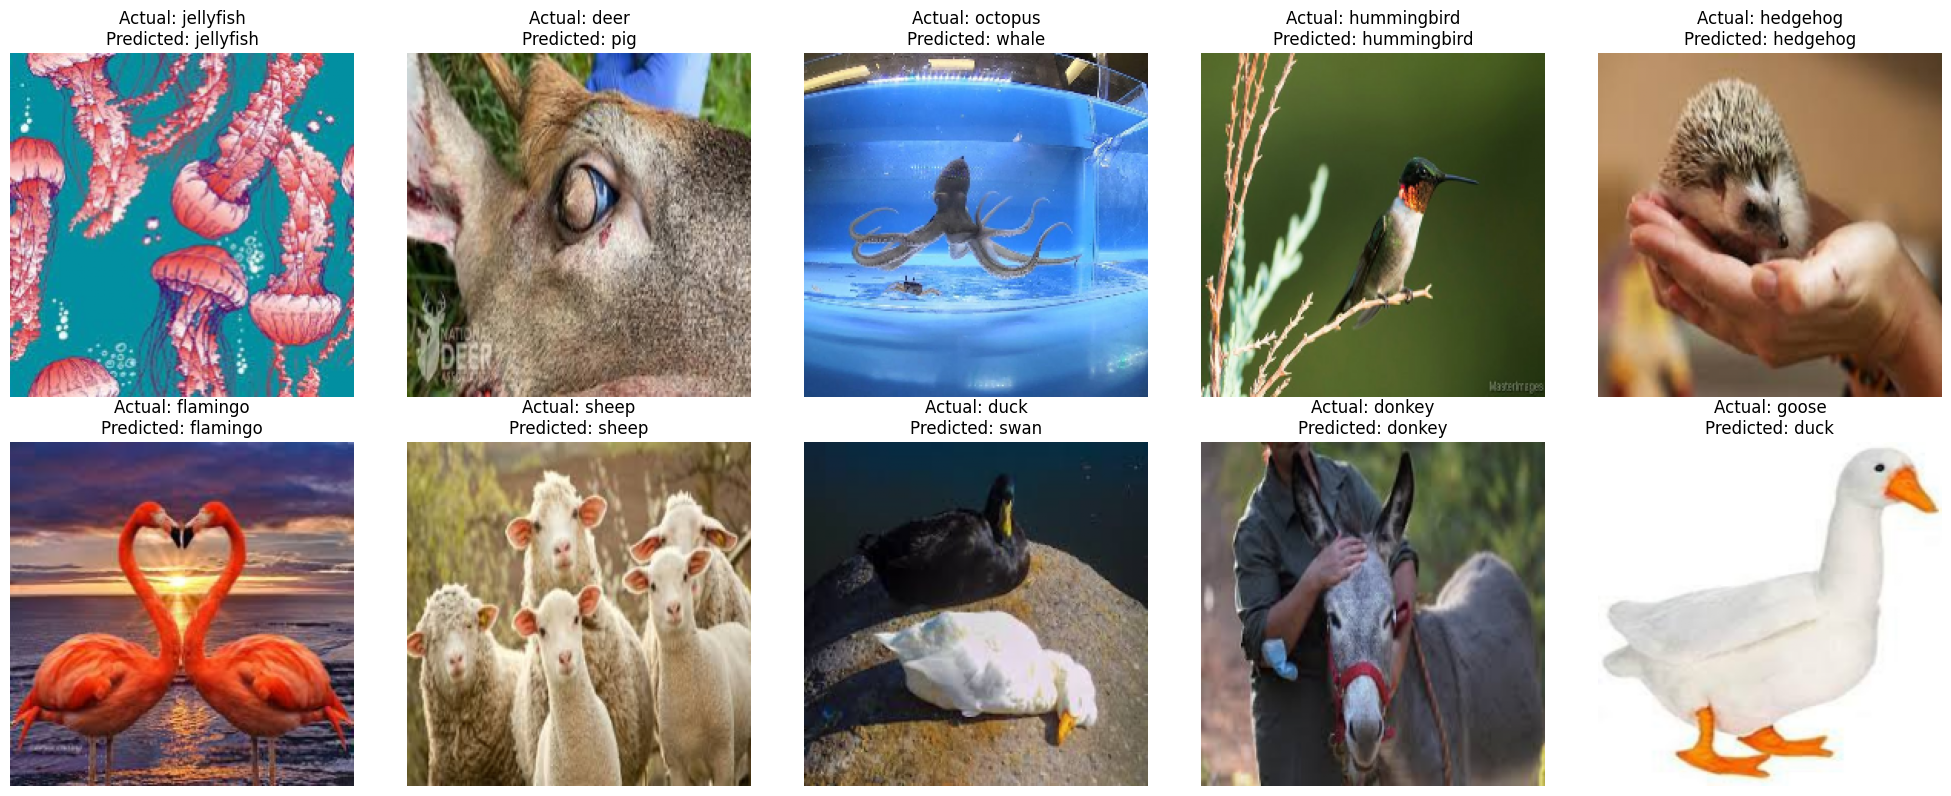

In [18]:
# Display sample predictions
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f'Actual: {label_encoder.inverse_transform([y_test[i]])[0]}\nPredicted: {label_encoder.inverse_transform([y_pred[i]])[0]}')
plt.tight_layout()
plt.show()

<div style="background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%); padding: 20px; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); text-align: center;">
    <h2 style="color: #2c3e50; font-family: 'Lucida Bright', Georgia, serif; font-size: 28px; margin-bottom: 10px;">
        👍 Enjoyed the Notebook?
    </h2>
    <p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #34495e; margin-bottom: 20px;">
        Please consider <span style="font-weight: bold; color: #e74c3c;">upvoting</span> to show your support!
    </p>
    <p style="font-family: 'Courier New', monospace; font-size: 16px; color: #7f8c8d;">
        Your feedback inspires me to create more insightful content. Thank you!
    </p>
</div>